# SOHC in ECCOv4-r4

Here we derive a time series of the subpolar ocean heat content (SOHC) in ECCOv4-r4. The SOHC is a fixed volume defined by the following limits:  

Latitude range: [45°N, 67°N]

Longitude range: [-100°E, 20°E]

Depth range: [-1000 m, 0 m]

#### Prepare environment

In [1]:
import numpy as np
import xarray as xr
from pprint import pprint
import pandas as pd
import importlib
import pyresample
import cartopy
import dask
import xgcm
import sys

#### Suppress warning messages for a cleaner presentation

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Import the ecco_v4_py library into Python

In [3]:
# tell python where to find ECCOv4-py
sys.path.append('/Users/dcjones3/ECCOv4-py/ECCOv4-py')

# import ecco_v4_py 
import ecco_v4_py as ecco

In [4]:
# import module for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#### Set directories for data locations

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

# Define main directory
base_dir = '/Users/dcjones3/ECCOv4-py/Version4/'

# Define ECCO version
ecco_version = 'v4r4'

# Define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/Release4'

#### Load ECCOv4 grid

In [6]:
# load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

#### Load for monthly mean data

In [7]:
year_start = 1993
year_end = 2017

data_dir= ECCO_dir + '/nctiles_monthly'

ecco_monthly_mean = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                        vars_to_load=['THETA'],\
                        years_to_load=range(year_start, year_end))

# merge into combined grid and vars dataset
ecco_ds = []
ecco_ds = xr.merge((ecco_grid , ecco_monthly_mean)).load()

loading files of  THETA


In [8]:
# create lat-lon mask 
ones = xr.ones_like(ecco_ds.XC)
sohc_maskC = ones.where((ecco_ds.YC >= 45)&
                        (ecco_ds.YC <= 67)&
                        (ecco_ds.XC >= -100)&
                        (ecco_ds.XC <= 20),0)

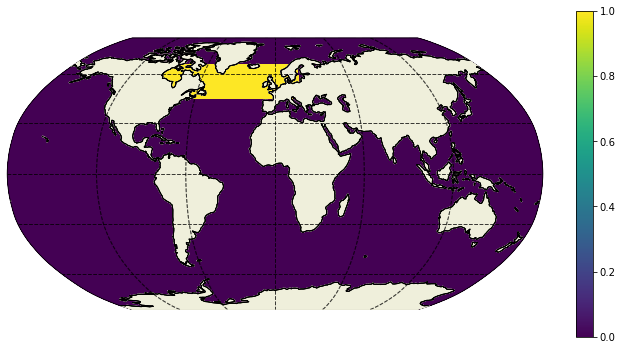

In [9]:
# plot the mask
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ecco_ds.XC,ecco_ds.YC,sohc_maskC,
                              projection_type='robin',
                              cmap='viridis',
                              user_lon_0=0,
                              show_colorbar=True);

In [10]:
# create vertical mask
onesK = xr.ones_like(ecco_ds.Z)
sohc_maskK = onesK.where(ecco_ds.Z>=-1000.0,0)

In [11]:
# calculate monthly climatology
theta_clim = ecco_ds.THETA.groupby('time.month').mean(dim='time')

# calculate monthly anomaly
theta_anom = ecco_ds.THETA.groupby('time.month') - theta_clim

In [12]:
# constants (chosen for consistency with EN4 analysis)
rhoconst = 1000   # kg/m^3
c_p = 4000        # J/(kg K)

# calculate ocean heat content
ohc = rhoconst * c_p * (theta_anom *
                   ecco_ds.rA *
                   ecco_ds.drF *
                   sohc_maskC *
                   sohc_maskK *
                   ecco_ds.hFacC).sum(dim=['tile', 'j', 'i','k'])

In [13]:
# remove model timestep from coordinate 
ohc = ohc.reset_coords(drop=True,names='timestep')

In [14]:
# set attributes
ohc.attrs["units"] = "J"
ohc.attrs["units_long_name"] = "Joules"
ohc.attrs["long_name"] = "Subpolar ocean heat content (SOHC)"
ohc.attrs["source"] = "ECCOv4 release 4"
ohc.attrs["source_url"] = "https://ecco-group.org/products-ECCO-V4r4.htm"
ohc.attrs["source_description_paper"] = "doi:10.5194/gmd-8-3071-2015"
ohc.attrs["latitude_range"] = "[45°N, 67°N]"
ohc.attrs["longitude_range"] = "[-100°E, 20°E]"
ohc.attrs["depth_range"] = "[0, 1056 m]"
ohc.attrs["time_range_start"] = "Start of 1993"
ohc.attrs["time_range_end"] = "End of 2016"
ohc.attrs["time_frequency"] = "monthly"
ohc.attrs["prepared_by"] = "Dan Jones, BAS"
ohc.attrs["prepared_date"] = "2 October 2020"
ohc.attrs["email_contact"] = "dannes@bas.ac.uk"
ohc.attrs["conda_environment_url"] = "https://anaconda.org/dannes/eccov4"

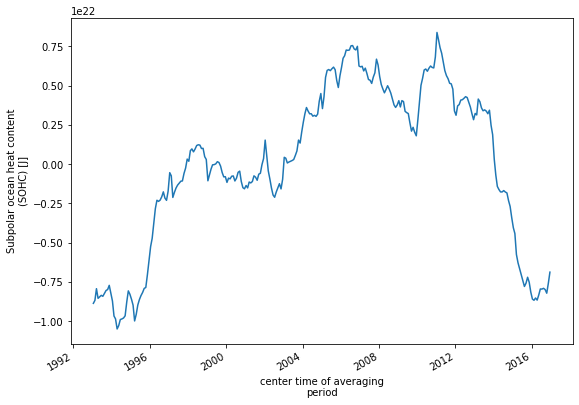

In [15]:
ohc.plot(size=6)

In [16]:
ohc

<xarray.DataArray (time: 288)>
array([-8.86446300e+21, -8.67653080e+21, -7.93113922e+21, -8.54717282e+21,
       -8.44979518e+21, -8.35541381e+21, -8.41641845e+21, -8.22836062e+21,
       -8.04796072e+21, -7.98620446e+21, -7.71911977e+21, -8.22425678e+21,
       -8.71894467e+21, -9.67164680e+21, -9.85842204e+21, -1.04969430e+22,
       -1.02807580e+22, -9.89648941e+21, -9.85770478e+21, -9.79945751e+21,
       -9.65927193e+21, -8.79089611e+21, -8.07138333e+21, -8.28701699e+21,
       -8.61317681e+21, -8.98221275e+21, -9.98602552e+21, -9.57016317e+21,
       -8.97242720e+21, -8.62651322e+21, -8.37066738e+21, -8.17243693e+21,
       -7.91455206e+21, -7.85543183e+21, -7.04641354e+21, -6.17750676e+21,
       -5.25423052e+21, -4.72453328e+21, -3.80223415e+21, -2.83803332e+21,
       -2.29970239e+21, -2.37218989e+21, -2.29270106e+21, -2.08093273e+21,
       -1.76552160e+21, -2.16255335e+21, -2.30545496e+21, -1.72230524e+21,
       -5.43036136e+20, -7.46067025e+20, -2.12090934e+21, -1.79886867e+21,
       -1.52318613e+21, -1.33466068e+21, -1.21043251e+21, -1.08756008e+21,
       -1.06869309e+21, -5.93325640e+20, -2.51054327e+20,  3.21085212e+20,
        1.83565493e+20,  8.57548740e+20,  9.70517654e+20,  7.81203951e+20,
        9.62786042e+20,  1.18541017e+21,  1.23291519e+21,  1.21227130e+21,
        9.94851529e+20,  1.00707501e+21,  4.77726595e+20,  2.97160365e+20,
       -1.06049641e+21, -6.81041690e+20, -3.27882266e+20, -4.49805717e+19,
       -3.05799994e+19,  1.57688518e+19,  1.55982542e+20,  1.03276440e+20,
...
        5.99570348e+21,  6.05779421e+21,  5.91409588e+21,  6.11019388e+21,
        6.24912265e+21,  6.15732471e+21,  6.12677890e+21,  6.82510676e+21,
        8.38590110e+21,  7.91875093e+21,  7.41703056e+21,  7.06498015e+21,
        6.49369957e+21,  5.95420873e+21,  5.63825858e+21,  5.44157592e+21,
        5.14911603e+21,  5.11341787e+21,  4.77608846e+21,  3.38621127e+21,
        3.11272091e+21,  3.70789573e+21,  3.79329471e+21,  4.08037865e+21,
        4.10263678e+21,  4.19353601e+21,  4.29646839e+21,  4.24115485e+21,
        3.94120426e+21,  3.63663739e+21,  3.20630341e+21,  2.83014159e+21,
        3.22837418e+21,  3.13499649e+21,  4.14500986e+21,  3.97803361e+21,
        3.58665954e+21,  3.39836066e+21,  3.45552077e+21,  3.37796816e+21,
        3.21078494e+21,  3.43410875e+21,  2.48168767e+21,  1.87625955e+21,
        3.09025313e+20, -6.91845546e+20, -1.41869024e+21, -1.61859037e+21,
       -1.76939741e+21, -1.77062805e+21, -1.68471434e+21, -1.77535251e+21,
       -1.83491915e+21, -2.31857233e+21, -2.69276786e+21, -3.40605268e+21,
       -4.04826652e+21, -4.42023753e+21, -5.75287086e+21, -6.28400638e+21,
       -6.65571271e+21, -7.04137876e+21, -7.37352791e+21, -7.79030993e+21,
       -7.58332418e+21, -7.20381819e+21, -7.52229001e+21, -8.15175773e+21,
       -8.59360249e+21, -8.66991279e+21, -8.52549988e+21, -8.65750516e+21,
       -8.33799235e+21, -7.95107270e+21, -7.95631310e+21, -7.90903303e+21,
       -7.98810767e+21, -8.21947487e+21, -7.59331803e+21, -6.87815014e+21])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2016-12-16T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:                     J
    units_long_name:           Joules
    long_name:                 Subpolar ocean heat content (SOHC)
    source:                    ECCOv4 release 4
    source_url:                https://ecco-group.org/products-ECCO-V4r4.htm
    source_description_paper:  doi:10.5194/gmd-8-3071-2015
    latitude_range:            [45°N, 67°N]
    longitude_range:           [-100°E, 20°E]
    depth_range:               [0, 1056 m]
    time_range_start:          Start of 1993
    time_range_end:            End of 2016
    time_frequency:            monthly
    prepared_by:               Dan Jones, BAS
    prepared_date:             2 October 2020
    email_contact:             dannes@bas.ac.uk
    conda_environment_url:     https://anaconda.org/dannes/e

#### Save as NetCDF file

In [17]:
ohc.to_netcdf("ACSIS_SOHC_ECCOv4r4_1993_to_2016.nc")